In [21]:
# Import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Connect to local SQLite database file
conn = sqlite3.connect("olap_assignment.db")
cur = conn.cursor()

Empty DataFrame
Columns: [category, name, total_qty]
Index: []


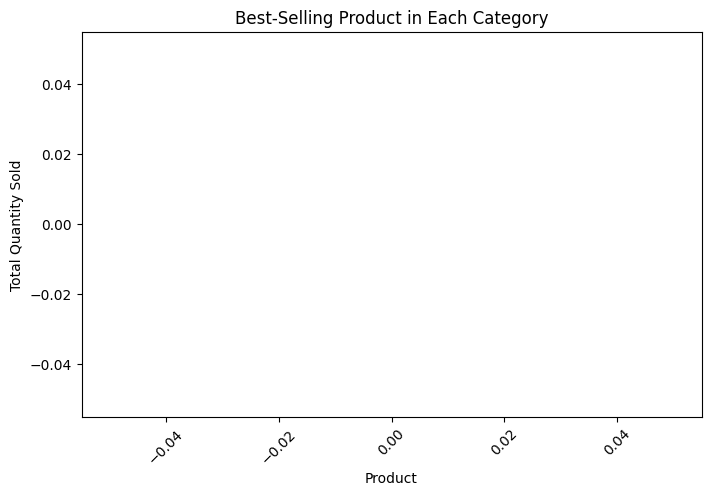

Empty DataFrame
Columns: [category, revenue]
Index: []


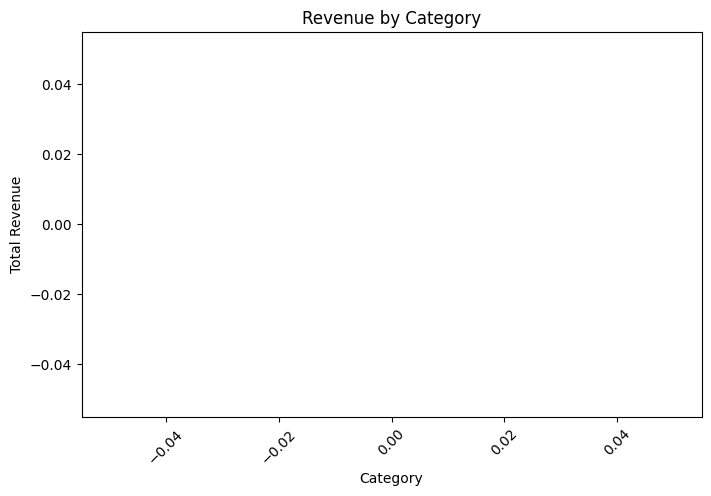

C:\Users\PC\AppData\Local\Temp\ipykernel_6660\122907385.py:178: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(pivot.fillna(0), aspect="auto")
C:\Users\PC\AppData\Local\Temp\ipykernel_6660\122907385.py:178: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(pivot.fillna(0), aspect="auto")


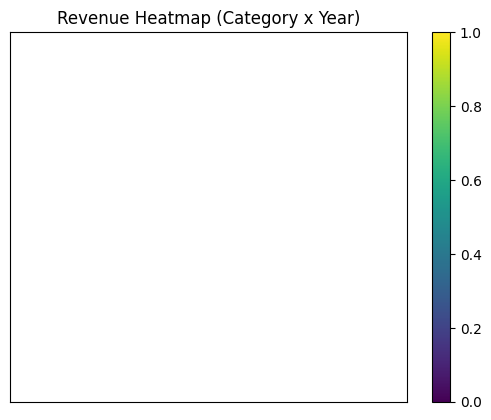

In [22]:
# Remove old tables if they exist
cur.executescript("""
DROP TABLE IF EXISTS sales;
DROP TABLE IF EXISTS products;
DROP TABLE IF EXISTS dates;
""")

# Products table (dimension)
cur.execute("""
CREATE TABLE products (
    product_id INTEGER PRIMARY KEY,
    category TEXT,
    name TEXT,
    price REAL
);
""")

# Dates table (dimension)
cur.execute("""
CREATE TABLE dates (
    date TEXT PRIMARY KEY,
    year INTEGER,
    quarter INTEGER,
    month INTEGER
);
""")

# Sales table (fact)
cur.execute("""
CREATE TABLE sales (
    sale_id INTEGER PRIMARY KEY AUTOINCREMENT,
    date TEXT,
    product_id INTEGER,
    quantity INTEGER,
    revenue REAL,
    FOREIGN KEY(date) REFERENCES dates(date),
    FOREIGN KEY(product_id) REFERENCES products(product_id)
);
""")

conn.commit()
# Add some products
products = [
    (1, "Electronics", "Smartphone A", 700.0),
    (2, "Electronics", "Laptop B", 1200.0),
    (3, "Home", "Blender X", 80.0),
    (4, "Home", "Toaster Y", 35.0),
    (5, "Clothing", "T-Shirt Z", 20.0),
    (6, "Clothing", "Jeans Q", 45.0)
]
cur.executemany("INSERT INTO products VALUES (?,?,?,?)", products)

# Generate dates (2023–2025)
start = datetime(2023, 1, 1)
end = datetime(2025, 12, 31)
dates = []
while start <= end:
    q = (start.month - 1) // 3 + 1
    dates.append((start.strftime("%Y-%m-%d"), start.year, q, start.month))
    start += timedelta(days=1)
cur.executemany("INSERT INTO dates VALUES (?,?,?,?)", dates)

# Generate random sales
np.random.seed(42)
all_dates = [d[0] for d in dates]
sales = []
for _ in range(3000):
    d = np.random.choice(all_dates)
    pid = np.random.choice([p[0] for p in products])
    qty = np.random.randint(1, 5)
    price = next(p[3] for p in products if p[0] == pid)
    revenue = round(qty * price * (1 + np.random.uniform(-0.05, 0.1)), 2)
    sales.append((d, pid, qty, revenue))
cur.executemany("INSERT INTO sales(date, product_id, quantity, revenue) VALUES (?,?,?,?)", sales)

conn.commit()
# Average revenue by category
q1 = """
SELECT p.category, ROUND(AVG(s.revenue),2) AS avg_revenue
FROM sales s JOIN products p ON s.product_id = p.product_id
GROUP BY p.category;
"""
pd.read_sql_query(q1, conn)
# Total sales per year
q2 = """
SELECT d.year, SUM(s.quantity) AS total_qty, ROUND(SUM(s.revenue),2) AS total_rev
FROM sales s JOIN dates d ON s.date = d.date
GROUP BY d.year;
"""
pd.read_sql_query(q2, conn)
# Best-selling product in each category
q3 = """
SELECT category, name, total_qty
FROM (
    SELECT p.category, p.name, SUM(s.quantity) AS total_qty
    FROM sales s
    JOIN products p ON s.product_id = p.product_id
    GROUP BY p.category, p.name
) sub
WHERE total_qty = (
    SELECT MAX(total_qty)
    FROM (
        SELECT p2.category, p2.name, SUM(s2.quantity) AS total_qty
        FROM sales s2
        JOIN products p2 ON s2.product_id = p2.product_id
        WHERE p2.category = sub.category
        GROUP BY p2.category, p2.name
    )
);
"""

# Run the query and store results
df_best = pd.read_sql_query(q3, conn)

# Show the results (to verify data is correct)
print(df_best)

# Plot the best-selling product in each category
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(df_best["name"], df_best["total_qty"])
plt.title("Best-Selling Product in Each Category")
plt.xlabel("Product")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.show()


# Load full sales data into pandas
df = pd.read_sql_query("""
SELECT s.*, p.category, p.name, d.year, d.quarter, d.month
FROM sales s
JOIN products p ON s.product_id = p.product_id
JOIN dates d ON s.date = d.date
""", conn)

# Revenue by category x year
pd.pivot_table(df, values="revenue", index="category", columns="year", aggfunc="sum")
# SQL fetch (Electronics in 2024)
detail = pd.read_sql_query("""
SELECT s.date, p.name, s.quantity, s.revenue, d.quarter
FROM sales s
JOIN products p ON s.product_id = p.product_id
JOIN dates d ON s.date = d.date
WHERE p.category = 'Electronics' AND d.year = 2024
""", conn)

# Pandas aggregation
detail.groupby(["name", "quarter"])[["quantity","revenue"]].sum()
# Slice: 2024 only
df[df["year"] == 2024].groupby("category")[["quantity","revenue"]].sum()
# Dice: Q1 2024, Electronics only
df[(df["year"]==2024)&(df["quarter"]==1)&(df["category"]=="Electronics")].groupby("name")[["quantity","revenue"]].sum()
# Roll-up: product -> category
df.groupby(["category","name"])["revenue"].sum().reset_index()
# Drill-down: year -> quarter -> month (Home category)
home = df[df["category"]=="Home"]
home.groupby("year")["revenue"].sum(), home.groupby(["year","quarter"])["revenue"].sum(), home.groupby(["year","month"])["revenue"].sum()
# Bar chart: total revenue by category
# Group by category and sum revenue
cat_rev = df.groupby("category")["revenue"].sum().reset_index()

# Show results
print(cat_rev)

# Plot properly
plt.figure(figsize=(8,5))
plt.bar(cat_rev["category"], cat_rev["revenue"])
plt.title("Revenue by Category")
plt.xlabel("Category")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.show()

# Heatmap: category x year
pivot = pd.pivot_table(df, values="revenue", index="category", columns="year", aggfunc="sum")
plt.imshow(pivot.fillna(0), aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Revenue Heatmap (Category x Year)")
plt.colorbar()
plt.show()

In [23]:
# Full data extraction from a realistic sales data

import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random

# Simulate 60 days of sales data
customers = ["Amazon", "Walmart", "Target", "BestBuy", "Costco", "eBay"]
data = []

# Define start date
start_date = datetime.date(2025, 4, 1)

# For loop to generate data
for i in range(61):  # 0 to 60 (61 days)
    date = start_date + datetime.timedelta(days=i)
    for _ in range(random.randint(3, 6)):  # 3 to 6 transactions per day
        data.append({
            "id": random.randint(1000, 9999),
            "customers": random.choice(customers),
            "date": date.isoformat(),
            "amount": random.randint(100, 2000),
            "last_updated": (
                datetime.datetime.combine(date, datetime.time()) +
                datetime.timedelta(
                    hours=random.randint(0, 23),
                    minutes=random.randint(0, 59),
                    seconds=random.randint(0, 59)
                )
            ).isoformat()
        })

# Convert to DataFrame and save
df = pd.DataFrame(data)
df.to_csv("sales_data.csv", index=False)
print("Sample of Full Data:")
print(df.head())

# Full data extraction from realistic sales data
df_full = pd.read_csv("sales_data.csv", parse_dates=['date', 'last_updated'])
print("\nFull Data Extracted:")
print(df_full.head())

# Incremental data extraction
last_extraction_date = datetime.datetime(2025, 4, 15, 12, 0, 0)
df_incremental = df_full[df_full['last_updated'] > last_extraction_date]
print(f"\nIncremental Data Extracted (after {last_extraction_date}):")
print(df_incremental.head())


Sample of Full Data:
     id customers        date  amount         last_updated
0  7896   BestBuy  2025-04-01     708  2025-04-01T04:40:48
1  6571    Costco  2025-04-01    1731  2025-04-01T08:18:31
2  2752    Costco  2025-04-01     775  2025-04-01T19:39:35
3  3177    Costco  2025-04-01    1576  2025-04-01T22:18:12
4  9308    Amazon  2025-04-02     882  2025-04-02T21:32:53

Full Data Extracted:
     id customers       date  amount        last_updated
0  7896   BestBuy 2025-04-01     708 2025-04-01 04:40:48
1  6571    Costco 2025-04-01    1731 2025-04-01 08:18:31
2  2752    Costco 2025-04-01     775 2025-04-01 19:39:35
3  3177    Costco 2025-04-01    1576 2025-04-01 22:18:12
4  9308    Amazon 2025-04-02     882 2025-04-02 21:32:53

Incremental Data Extracted (after 2025-04-15 12:00:00):
      id customers       date  amount        last_updated
69  8998   Walmart 2025-04-15     490 2025-04-15 23:25:59
71  2605    Amazon 2025-04-16    1911 2025-04-16 10:24:53
72  7670    Amazon 2025-04-16 